<a href="https://colab.research.google.com/github/Danilo-CVM/TCC/blob/Predict/V2%20-%20Previs%C3%A3o_Random_Forrest_aprimorada_Melhor_Resultado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Pendências:

##Exportar modelo treinado para não haver necessidade de treinamento em todos os testes.
##Criar código para previsão da próxima semana, ou seja, criar o código que será usado após a fase de testes para previsão da próxima semana da carteira.

In [1]:
# Importando Bibliotecas para extração de dados do Yhoo Finance
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
import datetime as dt
from pandas_datareader import data as pdr

yf.pdr_override()

     |████████████████████████████████| 5.5MB 6.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=204ef86a944916ce295dce7e111ae956dcd1b37013f2345f7bf667d5acd9c689
  Stored in directory: /tmp/pip-ephem-wheel-cache-mcvrf7iz/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


#Fonte:
https://github.com/areed1192/sigma_coding_youtube/blob/master/python/python-data-science/machine-learning/random-forest/random_forest_price_prediction.ipynb

### A fonte utilizada foi um paper que estuda a previsão da direção do mercado de ações utilizando classificadores baseados em árvores de decisão. 
### Utilizamos esse paper como base fazendo algumas alterações, e os resultados encontrados foram os mais precisos, de todas as técnicas utilizadas.

In [2]:
#Instalando Bibliotecas úteis

#Biblioteca para DropNA
!pip install --upgrade ta

from ta.utils import dropna

#Biblioteca de plotagem
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

  Created wheel for ta: filename=ta-0.7.0-cp36-none-any.whl size=28718 sha256=725ef746b34b1db13eb1284766a13e0cc8150872eaf953f0134ef58695d9c9f6
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [3]:
#Definindo dados da importação do banco de dados:

#Escolha a ação
stock= "^BVSP"

#Escolha o inicio do período
startyear=2006
startmonth=1
startday=1

start=dt.datetime(startyear,startmonth,startday)

#Escolha o final do período
endyear = 2018
endmonth = 12
endday = 20

now=dt.datetime(endyear,endmonth,endday)

#Rascunho - Código para a escolha dos últimos dados
#now=dt.datetime.now()

#df=pdr.get_data_yahoo(stock,start,now)
#Dado semanais
df=pdr.get_data_yahoo(stock,start,now, interval='1wk')


[*********************100%***********************]  1 of 1 completed


In [4]:
 #Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report



###Dados importados

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-01,33462.0,35529.0,32860.0,35475.0,35475.0,0
2006-01-08,35475.0,36286.0,34687.0,35897.0,35897.0,0
2006-01-15,35897.0,36979.0,35380.0,36695.0,36695.0,0
2006-01-22,36687.0,38804.0,36213.0,37822.0,37822.0,0
2006-01-29,37824.0,38508.0,36526.0,37262.0,37262.0,0


###Extraindo características de interesse dos dados impotados - Cálculo dos indicadores técnicos

In [6]:
price_data = df
price_data['change_in_price'] = price_data['Close'].diff()

In [7]:
# Calculando a RSI (Relative Strength Index) de 14 dias
n = 14


up_df, down_df = price_data[['change_in_price']].copy(), price_data[['change_in_price']].copy()

up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculando a EWMA (Exponential Weighted Moving Average).
ewma_up = up_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.head(30)

,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI
Date,,,,,,,,,,
2006-01-01,33462.0,35529.0,32860.0,35475.0,35475.0,0,NaN,NaN,NaN,NaN
2006-01-08,35475.0,36286.0,34687.0,35897.0,35897.0,0,422.0,0.0,422.0,100.000000
2006-01-15,35897.0,36979.0,35380.0,36695.0,36695.0,0,798.0,0.0,798.0,100.000000
2006-01-22,36687.0,38804.0,36213.0,37822.0,37822.0,0,1127.0,0.0,1127.0,100.000000
2006-01-29,37824.0,38508.0,36526.0,37262.0,37262.0,0,-560.0,560.0,0.0,76.771450
2006-02-05,37262.0,37813.0,36183.0,36975.0,36975.0,0,-287.0,287.0,0.0,67.499625
2006-02-12,36975.0,38642.0,35891.0,38422.0,38422.0,0,1447.0,0.0,1447.0,80.911180
2006-02-19,38418.0,38978.0,37747.0,38610.0,38610.0,0,188.0,0.0,188.0,82.023267
2006-02-26,38610.0,39367.0,38533.0,39240.0,39240.0,0,630.0,0.0,630.0,85.328268


In [8]:
# Calculando o Oscilador Estochastico
n = 14

low_14, high_14 = price_data[['Low']].copy(), price_data[['High']].copy()

low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

k_percent = 100 * ((price_data['Close'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

price_data.head(30)

,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
Date,,,,,,,,,,,,,
2006-01-01,33462.0,35529.0,32860.0,35475.0,35475.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-08,35475.0,36286.0,34687.0,35897.0,35897.0,0,422.0,0.0,422.0,100.000000,NaN,NaN,NaN
2006-01-15,35897.0,36979.0,35380.0,36695.0,36695.0,0,798.0,0.0,798.0,100.000000,NaN,NaN,NaN
2006-01-22,36687.0,38804.0,36213.0,37822.0,37822.0,0,1127.0,0.0,1127.0,100.000000,NaN,NaN,NaN
2006-01-29,37824.0,38508.0,36526.0,37262.0,37262.0,0,-560.0,560.0,0.0,76.771450,NaN,NaN,NaN
2006-02-05,37262.0,37813.0,36183.0,36975.0,36975.0,0,-287.0,287.0,0.0,67.499625,NaN,NaN,NaN
2006-02-12,36975.0,38642.0,35891.0,38422.0,38422.0,0,1447.0,0.0,1447.0,80.911180,NaN,NaN,NaN
2006-02-19,38418.0,38978.0,37747.0,38610.0,38610.0,0,188.0,0.0,188.0,82.023267,NaN,NaN,NaN
2006-02-26,38610.0,39367.0,38533.0,39240.0,39240.0,0,630.0,0.0,630.0,85.328268,NaN,NaN,NaN


In [9]:
# Calculando o Índice Williams %R
n = 14

low_14, high_14 = price_data[['Low']].copy(), price_data[['High']].copy()

low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

r_percent = ((high_14 - price_data['Close']) / (high_14 - low_14)) * - 100

price_data['r_percent'] = r_percent

price_data.head(30)

,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
Date,,,,,,,,,,,,,,
2006-01-01,33462.0,35529.0,32860.0,35475.0,35475.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-08,35475.0,36286.0,34687.0,35897.0,35897.0,0,422.0,0.0,422.0,100.000000,NaN,NaN,NaN,NaN
2006-01-15,35897.0,36979.0,35380.0,36695.0,36695.0,0,798.0,0.0,798.0,100.000000,NaN,NaN,NaN,NaN
2006-01-22,36687.0,38804.0,36213.0,37822.0,37822.0,0,1127.0,0.0,1127.0,100.000000,NaN,NaN,NaN,NaN
2006-01-29,37824.0,38508.0,36526.0,37262.0,37262.0,0,-560.0,560.0,0.0,76.771450,NaN,NaN,NaN,NaN
2006-02-05,37262.0,37813.0,36183.0,36975.0,36975.0,0,-287.0,287.0,0.0,67.499625,NaN,NaN,NaN,NaN
2006-02-12,36975.0,38642.0,35891.0,38422.0,38422.0,0,1447.0,0.0,1447.0,80.911180,NaN,NaN,NaN,NaN
2006-02-19,38418.0,38978.0,37747.0,38610.0,38610.0,0,188.0,0.0,188.0,82.023267,NaN,NaN,NaN,NaN
2006-02-26,38610.0,39367.0,38533.0,39240.0,39240.0,0,630.0,0.0,630.0,85.328268,NaN,NaN,NaN,NaN


In [10]:
# Calculando o indicador MACD
ema_26 = price_data['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

ema_9_macd = macd.ewm(span = 9).mean()

price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

price_data.head(30)

,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
Date,,,,,,,,,,,,,,,,
2006-01-01,33462.0,35529.0,32860.0,35475.0,35475.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2006-01-08,35475.0,36286.0,34687.0,35897.0,35897.0,0,422.0,0.0,422.0,100.000000,NaN,NaN,NaN,NaN,9.467949,5.259972
2006-01-15,35897.0,36979.0,35380.0,36695.0,36695.0,0,798.0,0.0,798.0,100.000000,NaN,NaN,NaN,NaN,36.809978,18.190302
2006-01-22,36687.0,38804.0,36213.0,37822.0,37822.0,0,1127.0,0.0,1127.0,100.000000,NaN,NaN,NaN,NaN,89.033456,42.188660
2006-01-29,37824.0,38508.0,36526.0,37262.0,37262.0,0,-560.0,560.0,0.0,76.771450,NaN,NaN,NaN,NaN,93.252845,57.379101
2006-02-05,37262.0,37813.0,36183.0,36975.0,36975.0,0,-287.0,287.0,0.0,67.499625,NaN,NaN,NaN,NaN,81.764139,63.988802
2006-02-12,36975.0,38642.0,35891.0,38422.0,38422.0,0,1447.0,0.0,1447.0,80.911180,NaN,NaN,NaN,NaN,138.539499,82.855595
2006-02-19,38418.0,38978.0,37747.0,38610.0,38610.0,0,188.0,0.0,188.0,82.023267,NaN,NaN,NaN,NaN,183.322834,106.999762
2006-02-26,38610.0,39367.0,38533.0,39240.0,39240.0,0,630.0,0.0,630.0,85.328268,NaN,NaN,NaN,NaN,242.801710,138.370685


In [11]:
# Calculando o indicador Price Rate of Change
n = 9

price_data['Price_Rate_Of_Change'] = price_data['Close'].transform(lambda x: x.pct_change(periods = n))

price_data.head(30)

,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
Date,,,,,,,,,,,,,,,,,
2006-01-01,33462.0,35529.0,32860.0,35475.0,35475.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2006-01-08,35475.0,36286.0,34687.0,35897.0,35897.0,0,422.0,0.0,422.0,100.000000,NaN,NaN,NaN,NaN,9.467949,5.259972,NaN
2006-01-15,35897.0,36979.0,35380.0,36695.0,36695.0,0,798.0,0.0,798.0,100.000000,NaN,NaN,NaN,NaN,36.809978,18.190302,NaN
2006-01-22,36687.0,38804.0,36213.0,37822.0,37822.0,0,1127.0,0.0,1127.0,100.000000,NaN,NaN,NaN,NaN,89.033456,42.188660,NaN
2006-01-29,37824.0,38508.0,36526.0,37262.0,37262.0,0,-560.0,560.0,0.0,76.771450,NaN,NaN,NaN,NaN,93.252845,57.379101,NaN
2006-02-05,37262.0,37813.0,36183.0,36975.0,36975.0,0,-287.0,287.0,0.0,67.499625,NaN,NaN,NaN,NaN,81.764139,63.988802,NaN
2006-02-12,36975.0,38642.0,35891.0,38422.0,38422.0,0,1447.0,0.0,1447.0,80.911180,NaN,NaN,NaN,NaN,138.539499,82.855595,NaN
2006-02-19,38418.0,38978.0,37747.0,38610.0,38610.0,0,188.0,0.0,188.0,82.023267,NaN,NaN,NaN,NaN,183.322834,106.999762,NaN
2006-02-26,38610.0,39367.0,38533.0,39240.0,39240.0,0,630.0,0.0,630.0,85.328268,NaN,NaN,NaN,NaN,242.801710,138.370685,NaN


In [12]:
# Para o Calculo do indicador OBV (On Balance Volume) - utilizamos uma biblioteca chamada Technical Analysis
from ta.volume import OnBalanceVolumeIndicator
indicator_obv = OnBalanceVolumeIndicator(close=df["Close"], volume=df["Volume"])
price_data['On Balance Volume'] = indicator_obv.on_balance_volume()

In [13]:
price_data.head()

,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
Date,,,,,,,,,,,,,,,,,,
2006-01-01,33462.0,35529.0,32860.0,35475.0,35475.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
2006-01-08,35475.0,36286.0,34687.0,35897.0,35897.0,0,422.0,0.0,422.0,100.00000,NaN,NaN,NaN,NaN,9.467949,5.259972,NaN,0
2006-01-15,35897.0,36979.0,35380.0,36695.0,36695.0,0,798.0,0.0,798.0,100.00000,NaN,NaN,NaN,NaN,36.809978,18.190302,NaN,0
2006-01-22,36687.0,38804.0,36213.0,37822.0,37822.0,0,1127.0,0.0,1127.0,100.00000,NaN,NaN,NaN,NaN,89.033456,42.188660,NaN,0
2006-01-29,37824.0,38508.0,36526.0,37262.0,37262.0,0,-560.0,560.0,0.0,76.77145,NaN,NaN,NaN,NaN,93.252845,57.379101,NaN,0


In [14]:
# Criando a coluna a ser prevista
'''
    Nesse caso, vamos criar uma coluna de saída que será 1 se o preço de fechamento no momento 't' for maior que 't-1' e -1 caso contrário.
    Em outras palavras, se o preço de fechamento de hoje for maior que o preço de fechamento de ontem, seria 1.
    '''

close_groups = price_data['Close']

close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

price_data['Prediction'] = close_groups

# Aqui, para tornar o classificador binário, vamos transformar os dias sem alterações no preço (eventos extremamente raros) de 0 para 1.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

price_data.head(50)


,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
Date,,,,,,,,,,,,,,,,,,,
2006-01-01,33462.0,35529.0,32860.0,35475.0,35475.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0,NaN
2006-01-08,35475.0,36286.0,34687.0,35897.0,35897.0,0,422.0,0.0,422.0,100.000000,NaN,NaN,NaN,NaN,9.467949,5.259972,NaN,0,1.0
2006-01-15,35897.0,36979.0,35380.0,36695.0,36695.0,0,798.0,0.0,798.0,100.000000,NaN,NaN,NaN,NaN,36.809978,18.190302,NaN,0,1.0
2006-01-22,36687.0,38804.0,36213.0,37822.0,37822.0,0,1127.0,0.0,1127.0,100.000000,NaN,NaN,NaN,NaN,89.033456,42.188660,NaN,0,1.0
2006-01-29,37824.0,38508.0,36526.0,37262.0,37262.0,0,-560.0,560.0,0.0,76.771450,NaN,NaN,NaN,NaN,93.252845,57.379101,NaN,0,-1.0
2006-02-05,37262.0,37813.0,36183.0,36975.0,36975.0,0,-287.0,287.0,0.0,67.499625,NaN,NaN,NaN,NaN,81.764139,63.988802,NaN,0,-1.0
2006-02-12,36975.0,38642.0,35891.0,38422.0,38422.0,0,1447.0,0.0,1447.0,80.911180,NaN,NaN,NaN,NaN,138.539499,82.855595,NaN,0,1.0
2006-02-19,38418.0,38978.0,37747.0,38610.0,38610.0,0,188.0,0.0,188.0,82.023267,NaN,NaN,NaN,NaN,183.322834,106.999762,NaN,0,1.0
2006-02-26,38610.0,39367.0,38533.0,39240.0,39240.0,0,630.0,0.0,630.0,85.328268,NaN,NaN,NaN,NaN,242.801710,138.370685,NaN,0,1.0


In [15]:

# Removendo colunas com valores NaN
print('Antes do NaN Drop tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

price_data = price_data.dropna()

print('Depois do NaN Drop temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

price_data.head()

Antes do NaN Drop tinhamos 677 linhas e 19 colunas
Depois do NaN Drop temos 664 linhas e 19 colunas


,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
Date,,,,,,,,,,,,,,,,,,,
2006-04-02,37952.0,39397.0,37952.0,38926.0,38926.0,0,974.0,0.0,974.0,64.394263,32860.0,39397.0,92.794860,-7.205140,184.481799,150.189205,0.044657,0,1.0
2006-04-09,38927.0,38927.0,37816.0,38082.0,38082.0,0,-844.0,844.0,0.0,54.568018,34687.0,39397.0,72.080679,-27.919321,172.516326,154.817472,0.029939,0,-1.0
2006-04-16,38086.0,40278.0,38086.0,39775.0,39775.0,0,1693.0,0.0,1693.0,66.425901,35380.0,40278.0,89.730502,-10.269498,263.948547,177.275834,0.035214,0,1.0
2006-04-23,39775.0,40425.0,39577.0,40363.0,40363.0,0,588.0,0.0,588.0,69.605079,35891.0,40425.0,98.632554,-1.367446,366.790897,216.052008,0.045403,0,1.0
2006-04-30,40365.0,41449.0,40277.0,41417.0,41417.0,0,1054.0,0.0,1054.0,74.582980,35891.0,41449.0,99.424253,-0.575747,507.503263,275.411586,0.055479,0,1.0


In [16]:

# Separando a base de dados para treino e teste.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Criando um Classificador Random Forest
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

rand_frst_clf.fit(X_train, y_train)

# Fazendo Previsões
y_pred = rand_frst_clf.predict(X_test)

In [17]:
# Mostrando a Acurácia do Modelo.
print('Previsão correta (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Previsão correta (%):  72.89156626506023


In [18]:
# Definindo traget names
target_names = ['Down Day', 'Up Day']

# Contruindo um classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Criando um data frame e transpondo para facilitar a leitura.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.714286,0.705128,0.709677,78.000000
Up Day,0.741573,0.750000,0.745763,88.000000
accuracy,0.728916,0.728916,0.728916,0.728916
macro avg,0.727929,0.727564,0.727720,166.000000
weighted avg,0.728751,0.728916,0.728807,166.000000


Accuracy: 0.7289156626506024
Percision: 0.7415730337078652
Recall: 0.75
Specificity: 0.7051282051282052


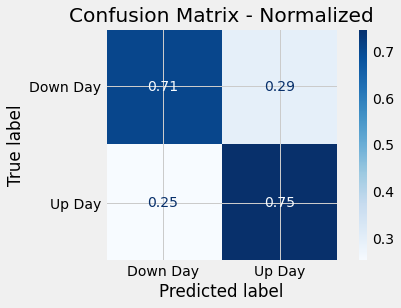

In [19]:
#Criando uma matriz de confusão

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [20]:
# Calculando a importancia de cada indicador na qualidade da classificação

feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

k_percent               0.197688
r_percent               0.189201
RSI                     0.189034
MACD                    0.159021
Price_Rate_Of_Change    0.154622
On Balance Volume       0.110435
dtype: float64

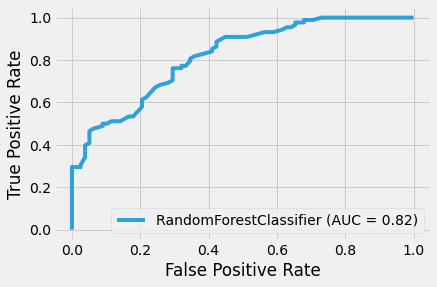

In [21]:
# Plotando uma curva ROC.

rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

In [22]:
print('Random Forest Out-Of-Bag Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Score: 0.7068273092369478


In [23]:
#Vamos tentar chegar ao melhor resultado possível, alterando as variáveis do classificador

# Número de árvores
n_estimators = list(range(200, 2000, 200))

# Número de características a serem consideradas em cada divisão
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum depht

max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Número mínimo de amostras necessárias para dividir um nó

min_samples_split = [2, 5, 10, 20, 30, 40]

# Número mínimo de amostras necessárias em cada nó folha
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Método de seleção de amostras para treinar cada árvore
bootstrap = [True, False]

# Criando a random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [24]:
# Novo classificador de floresta aleatório para abrigar parâmetros ideais
rf = RandomForestClassifier()

# Especifique os detalhes de nossa Pesquisa Randomizada
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Ajustar o modelo de pesquisa aleatória
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [25]:
# Com o novo Classificador Aleatório treinado, podemos prosseguir com nossas etapas regulares de previsão.
rf_random.predict(X_test)


'''
    ACCURACY
'''

print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''

target_names = ['Down Day', 'Up Day']

report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

Correct Prediction (%):  76.50602409638554


,precision,recall,f1-score,support
Down Day,0.714286,0.705128,0.709677,78.000000
Up Day,0.741573,0.750000,0.745763,88.000000
accuracy,0.728916,0.728916,0.728916,0.728916
macro avg,0.727929,0.727564,0.727720,166.000000
weighted avg,0.728751,0.728916,0.728807,166.000000


k_percent               0.197688
r_percent               0.189201
RSI                     0.189034
MACD                    0.159021
Price_Rate_Of_Change    0.154622
On Balance Volume       0.110435
dtype: float64

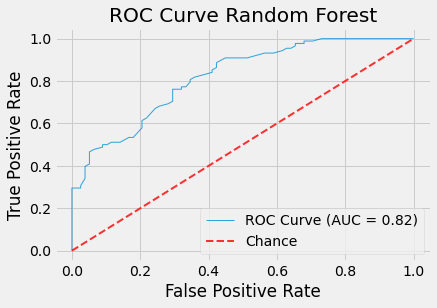

In [26]:
#Plotando uma nova Curva ROC

fig, ax = plt.subplots()

rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

ax.legend(loc="lower right")

plt.show()

In [27]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=16, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##Aplicando o modelo nos dados novos do iBovespa

In [28]:
#Definindo dados da importação do banco de dados:

#Escolha a ação
stock= "^BVSP"

#Escolha o inicio do período
startyear=2019
startmonth=1
startday=1

start=dt.datetime(startyear,startmonth,startday)

#Escolha o final do período
endyear = 2019
endmonth = 12
endday = 20

now=dt.datetime(endyear,endmonth,endday)

#Rascunho - Código para a escolha dos últimos dados
#now=dt.datetime.now()

#df=pdr.get_data_yahoo(stock,start,now)
#Dado semanais
df_bvsp=pdr.get_data_yahoo(stock,start,now, interval='1wk')

[*********************100%***********************]  1 of 1 completed


In [29]:
price_data_bvsp = df_bvsp
price_data_bvsp['change_in_price'] = price_data_bvsp['Close'].diff()

# RSI
n = 14

up_df_bvsp, down_df_bvsp = price_data_bvsp[['change_in_price']].copy(), price_data_bvsp[['change_in_price']].copy()

up_df_bvsp.loc['change_in_price'] = up_df_bvsp.loc[(up_df_bvsp['change_in_price'] < 0), 'change_in_price'] = 0

down_df_bvsp.loc['change_in_price'] = down_df_bvsp.loc[(down_df_bvsp['change_in_price'] > 0), 'change_in_price'] = 0

down_df_bvsp['change_in_price'] = down_df_bvsp['change_in_price'].abs()

ewma_up_bvsp = up_df_bvsp['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down_bvsp = down_df_bvsp['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength_bvsp = ewma_up_bvsp / ewma_down_bvsp

relative_strength_index_bvsp = 100.0 - (100.0 / (1.0 + relative_strength_bvsp))

price_data_bvsp['down_days'] = down_df_bvsp['change_in_price']
price_data_bvsp['up_days'] = up_df_bvsp['change_in_price']
price_data_bvsp['RSI'] = relative_strength_index_bvsp


#Oscilador Estocastico
n = 14

low_14_bvsp, high_14_bvsp = price_data_bvsp[['Low']].copy(), price_data_bvsp[['High']].copy()

low_14_bvsp = low_14_bvsp['Low'].transform(lambda x: x.rolling(window = n).min())
high_14_bvsp = high_14_bvsp['High'].transform(lambda x: x.rolling(window = n).max())

k_percent_bvsp = 100 * ((price_data_bvsp['Close'] - low_14_bvsp) / (high_14_bvsp - low_14_bvsp))

price_data_bvsp['low_14'] = low_14_bvsp
price_data_bvsp['high_14'] = high_14_bvsp
price_data_bvsp['k_percent'] = k_percent_bvsp




# Williams %R
n = 14

low_14_bvsp, high_14_bvsp = price_data_bvsp[['Low']].copy(), price_data_bvsp[['High']].copy()

low_14_bvsp = low_14_bvsp['Low'].transform(lambda x: x.rolling(window = n).min())
high_14_bvsp = high_14_bvsp['High'].transform(lambda x: x.rolling(window = n).max())

r_percent_bvsp = ((high_14_bvsp - price_data_bvsp['Close']) / (high_14_bvsp - low_14_bvsp)) * - 100

price_data_bvsp['r_percent'] = r_percent_bvsp


# MACD
ema_26_bvsp = price_data_bvsp['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12_bvsp = price_data_bvsp['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd_bvsp = ema_12_bvsp - ema_26_bvsp

ema_9_macd_bvsp = macd_bvsp.ewm(span = 9).mean()

price_data_bvsp['MACD'] = macd_bvsp
price_data_bvsp['MACD_EMA'] = ema_9_macd_bvsp


# Price Rate of Change
n = 9

price_data_bvsp['Price_Rate_Of_Change'] = price_data_bvsp['Close'].transform(lambda x: x.pct_change(periods = n))

# OBV

indicator_obv_bvsp = OnBalanceVolumeIndicator(close=df_bvsp["Close"], volume=df_bvsp["Volume"])
price_data_bvsp['On Balance Volume'] = indicator_obv_bvsp.on_balance_volume()


In [30]:
#Coluna de PRevisão

close_groups_bvsp = price_data_bvsp['Close']

close_groups_bvsp = close_groups_bvsp.transform(lambda x : np.sign(x.diff()))

price_data_bvsp['Prediction'] = close_groups_bvsp

price_data_bvsp.loc[price_data_bvsp['Prediction'] == 0.0] = 1.0

print('Antes do NaN Drop tinhamos {} linhas e {} colunas'.format(price_data_bvsp.shape[0], price_data_bvsp.shape[1]))

price_data_bvsp = price_data_bvsp.dropna()

print('Depois do NaN Drop temos {} linhas e {} colunas'.format(price_data_bvsp.shape[0], price_data_bvsp.shape[1]))


Antes do NaN Drop tinhamos 51 linhas e 19 colunas
Depois do NaN Drop temos 38 linhas e 19 colunas


In [31]:
#Separando entrada e saída
X_Cols_bvsp = price_data_bvsp[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols_bvsp = price_data_bvsp['Prediction']

# Make predictions
y_pred_bvsp = rf_random.predict(X_Cols_bvsp)

In [32]:
print('Correct Prediction (%): ', accuracy_score(Y_Cols_bvsp, rf_random.predict(X_Cols_bvsp), normalize = True) * 100.0)

Correct Prediction (%):  78.94736842105263


Accuracy: 0.7894736842105263
Percision: 0.8214285714285714
Recall: 0.8846153846153846
Specificity: 0.5833333333333334


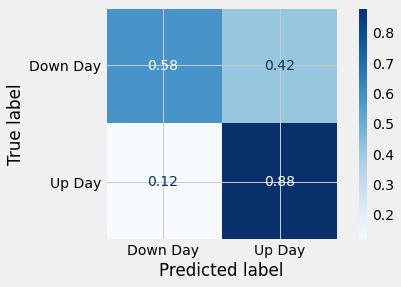

In [33]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix_bvsp = confusion_matrix(Y_Cols_bvsp, y_pred_bvsp)

true_negatives_bvsp = rf_matrix_bvsp[0][0]
false_negatives_bvsp = rf_matrix_bvsp[1][0]
true_positives_bvsp = rf_matrix_bvsp[1][1]
false_positives_bvsp = rf_matrix_bvsp[0][1]

accuracy_bvsp = (true_negatives_bvsp + true_positives_bvsp) / (true_negatives_bvsp + true_positives_bvsp + false_negatives_bvsp + false_positives_bvsp)
percision_bvsp = true_positives_bvsp / (true_positives_bvsp + false_positives_bvsp)
recall_bvsp = true_positives_bvsp / (true_positives_bvsp + false_negatives_bvsp)
specificity_bvsp = true_negatives_bvsp / (true_negatives_bvsp + false_positives_bvsp)

print('Accuracy: {}'.format(float(accuracy_bvsp)))
print('Percision: {}'.format(float(percision_bvsp)))
print('Recall: {}'.format(float(recall_bvsp)))
print('Specificity: {}'.format(float(specificity_bvsp)))

disp_bvsp = plot_confusion_matrix(rf_random, X_Cols_bvsp, Y_Cols_bvsp, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()